In [15]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    print('gpu', gpu)
    tf.config.experimental.set_memory_growth(gpu, True)
    print('memory growth:' , tf.config.experimental.get_memory_growth(gpu))
import os

data_dir = '/home/dawidkubicki/Datasets/jena_climate'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(len(header))
print(header)

15
['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']


In [16]:
#change those lines into the numpy table
import numpy as np
float_data = np.zeros((len(lines),len(header)-1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values


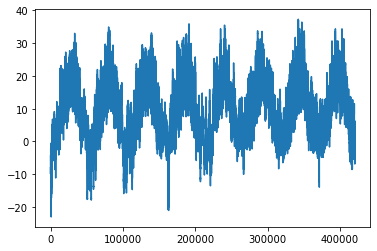

In [17]:
from matplotlib import pyplot as plt

temp = float_data[:, 1]  # Temeperatura (stopnie Celsjusza)
plt.plot(range(len(temp)), temp)
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

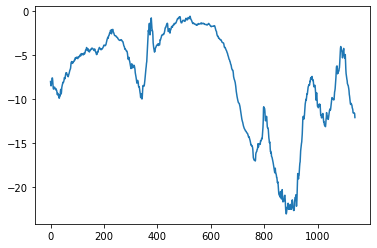

In [18]:
#let's look at 10 days of changing weather
plt.plot(range(1140), temp[:1140])
plt.show

In [19]:
#data normalization
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

In [20]:
#generator
def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
        i = min_index + lookback
        while 1:
            if shuffle:
                rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
            else:
                if i + batch_size >= max_index:
                    i = min_index + lookback
                rows = np.arrange(i, min(i + batch_size, max_index))
                i += len(rows)
            samples = np.zeros((len(rows),
                               lookback // step,
                               data.shape[-1]))
            targets = np.zeros((len(rows),))
            for j, row in enumarate(rows):
                inidices = range(rows[j] - lookback, rows[j], step)
                samples[j] = data[indices]
                targets[j] = data[rows[j] + delay][1]
            yield samples, targets

In [21]:
#prepare generators
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=0,
                     max_index=200000,
                     shuffle=True,
                     step=step,
                     batch_size=batch_size)

val_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=200001,
                     max_index=300000,
                     step=step,
                     batch_size=batch_size)

test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

val_steps = (300000 - 200001 - lookback) // batch_size

val_steps = (len(float_data) - 300001 - lookback) // batch_size

In [26]:
#let's prepare a simple model to have a refferrence
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss="mae")
history = model.fit(train_gen,
                    steps_per_epoch=500,
                    epochs=20,
                    validation_data=val_gen,
                    validation_steps=val_steps)

StopIteration: 